<a href="https://colab.research.google.com/github/antoronson/Vision-Based-Tracking/blob/dev/Object_Tracking_From_Video_Stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install ultralytics
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import imageio



In [3]:
from IPython.display import HTML

from base64 import b64encode

def play_mp4(file_path):
  mp4 = open(file_path, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  # Add "return" here!
  return HTML(f"""
  <video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
  </video>
  """)

In [4]:
def recreate_empty_dir(dir_path):
  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  os.makedirs(dir_path, exist_ok = True)

In [5]:
model = YOLO('yolov8n.pt')

dir = "/content/drive/MyDrive/datasets/yolo_video"

input_file = "input_file.mp4"

output_file = "output_file.mp4"

out_gif_file = "output_gif_file.gif"

input_path = os.path.join(dir, input_file)

output_path = os.path.join(dir, output_file)
output_gif_path = os.path.join(dir, out_gif_file)

save_folder = "images"
output_save_images_folder = os.path.join(dir, save_folder)
recreate_empty_dir(output_save_images_folder)

#play_mp4(input_path)

In [10]:
from google.colab.patches import cv2_imshow
from collections import defaultdict

cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print (f"Width of video: {width}")
print (f"Height of video: {height}")
print (f"FPS of video: {fps}")

#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out_write = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
out_write = None
frame_count = 0
gif_frames = []
tracks = defaultdict(list)
tracks.clear()
assert len(tracks) == 0
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  #results = model.track(frame, persist=True, classes=[2], conf=0.4)
  #/content/ultralytics
  #/content/ultralytics/ultralytics/cfg/trackers/bytetrack_modified.yml
  results = model.track(frame,
                        tracker="/content/ultralytics/ultralytics/cfg/trackers/bytetrack_modified.yml",
                        persist=True,
                        classes=[2, 3, 5, 7],
                        iou=0.5,
                        conf=0.25)  # With previous run, approx 84 cars were detected. Now after bytetrack file is included, a new search will be done

  frame_count += 1
  ########################
  # Recording trajectory
  ########################
  for box in results[0].boxes:
    if box.id is None:
      continue
    track_id = int(box.id)
    x1,x2,y1,y2 = box.xyxy[0].tolist()

    ########################
    # Cropping and saving
    # First time track id
    ########################
    if track_id not in tracks:
      h,w,_ = frame.shape
      x1 = max(0, int(x1))
      y1 = max(0, int(y1))
      x2 = min(w, int(x2))
      y2 = min(h, int(y2))

      crop = frame[y1:y2, x1:x2]
      if crop.size >0:
        filename = f"{output_save_images_folder}/track_{track_id}.jpg"
        cv2.imwrite(filename, crop)


    ########################
    # Calculating Mid Point
    ########################

    cx = (x1+x2)/2
    cy = (y1+y2)/2
    tracks[track_id].append({
        "frame_id": frame_count,
        "pos_x": cx,
        "pos_y":cy
    })

  marked_frame = results[0].plot()

  print(f"Processing the frame {frame_count}")
  #######################
  # Write to Mp4 file
  #######################
  """
  if out_write is None:
    h,w,_ = marked_frame.shape
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_write = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

  out_write.write(marked_frame)

  #######################
  # Write to Gif file
  #######################
  marked_frame_rgb = cv2.cvtColor(marked_frame, cv2.COLOR_BGR2RGB)
  small_frame = cv2.resize(marked_frame_rgb, (640, 360))
  out_write.write(marked_frame)
  #if frame_count%5 == 0: Trying to write all gif frames (greedy)
  gif_frames.append(small_frame)
  """

cap.release()
cv2.destroyAllWindows()


# Converting to Gif

#imageio.mimsave(output_gif_path, gif_frames, fps=5)


Width of video: 3840
Height of video: 2160
FPS of video: 60

0: 384x640 3 cars, 2 buss, 1 truck, 51.5ms
Speed: 3.4ms preprocess, 51.5ms inference, 47.5ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 1

0: 384x640 3 cars, 3 buss, 9.2ms
Speed: 5.4ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 2

0: 384x640 4 cars, 1 bus, 9.5ms
Speed: 4.3ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 3

0: 384x640 3 cars, 2 buss, 1 truck, 27.6ms
Speed: 6.9ms preprocess, 27.6ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 4

0: 384x640 3 cars, 3 buss, 9.6ms
Speed: 3.5ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 5

0: 384x640 3 cars, 1 bus, 1 truck, 9.3ms
Speed: 4.1ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Processing the 

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

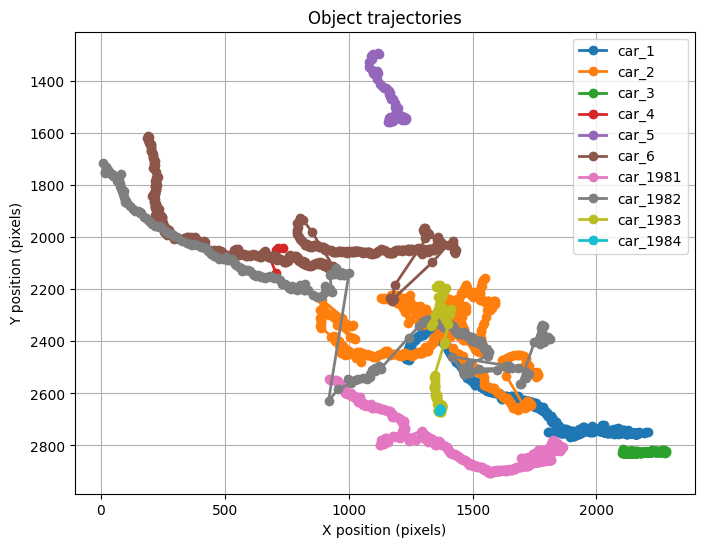

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for track_id, points in tracks.items():
    if len(points) < 2:
        continue  # skip very short tracks

    xs = [p["pos_x"] for p in points]
    ys = [p["pos_y"] for p in points]

    plt.plot(xs, ys, marker='o', linewidth=2, label=f"car_{track_id}")

plt.xlabel("X position (pixels)")
plt.ylabel("Y position (pixels)")
plt.title("Object trajectories")
plt.gca().invert_yaxis()  # important for image coordinates
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Using bytetrack to reduce the number of duplicates
model_bytetrack = YOLO('yolov8n.pt')
cap_bytetrack = cv2.VideoCapture(input_path)
width = int(cap_bytetrack.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_bytetrack.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap_bytetrack.get(cv2.CAP_PROP_FPS))
print (f"Width of video: {width}")
print (f"Height of video: {height}")
print (f"FPS of video: {fps}")

#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out_write = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
out_write = None
frame_count = 0
gif_frames = []
tracks_bytetrack = defaultdict(list)

while cap_bytetrack.isOpened():
  ret, frame = cap_bytetrack.read()
  if not ret:
    break
  results = model_bytetrack.track(frame, tracker="bytetrack.yaml", persist=True, classes=[2], conf=0.4)
  frame_count += 1
  ########################
  # Recording trajectory
  ########################
  for box in results[0].boxes:
    if box.id is None:
      continue
    track_id = int(box.id)
    x1,x2,y1,y2 = box.xyxy[0].tolist()
    cx = (x1+x2)/2
    cy = (y1+y2)/2
    tracks_bytetrack[track_id].append({
        "frame_id": frame_count,
        "pos_x": cx,
        "pos_y":cy
    })

  marked_frame = results[0].plot()

  print(f"Processing the frame {frame_count}")
cap_bytetrack.release()
cv2.destroyAllWindows()


Width of video: 3840
Height of video: 2160
FPS of video: 60

0: 384x640 3 cars, 22.2ms
Speed: 3.9ms preprocess, 22.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 1

0: 384x640 3 cars, 28.2ms
Speed: 6.6ms preprocess, 28.2ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 2

0: 384x640 4 cars, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 3

0: 384x640 3 cars, 9.4ms
Speed: 4.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 4

0: 384x640 3 cars, 27.9ms
Speed: 8.5ms preprocess, 27.9ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 5

0: 384x640 3 cars, 19.2ms
Speed: 5.4ms preprocess, 19.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Processing the frame 6

0: 384x640 3 cars, 19.9ms
Speed: 5.7ms preprocess, 19.9ms inf

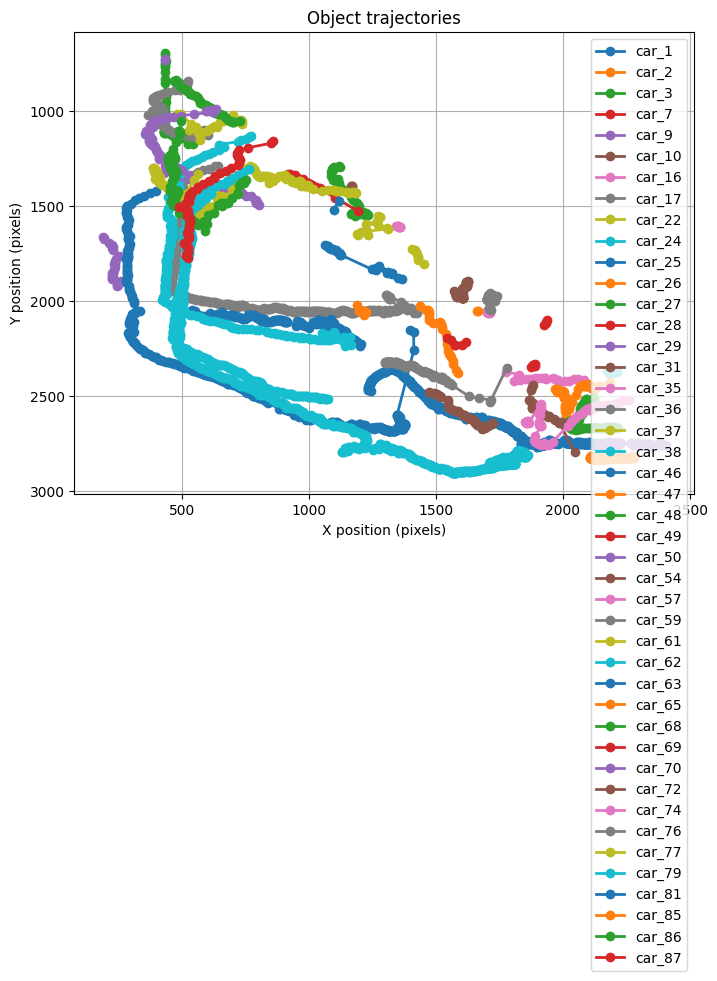

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for track_id, points in tracks_bytetrack.items():
    if len(points) < 2:
        continue  # skip very short tracks

    xs = [p["pos_x"] for p in points]
    ys = [p["pos_y"] for p in points]

    plt.plot(xs, ys, marker='o', linewidth=2, label=f"car_{track_id}")

plt.xlabel("X position (pixels)")
plt.ylabel("Y position (pixels)")
plt.title("Object trajectories")
plt.gca().invert_yaxis()  # important for image coordinates
plt.legend()
plt.grid(True)
plt.show()

As we see the above model is not sophisticated. Though it plots the box arounf object and stores as image, the output is not how it was expected. Further the algorithm cannot detect the van again frame to frame and the busses remains undetected. Thus the algorithm has to be improved and the data presentation format should also be changed.

# 07.01.2026:
During the test the model kept crashing. When noticed, we ended up with the problem of buffer overflowing. Therefore, the image will be written back to mp4 file on the fly and then the video with the embedded frame will be played back. A second gif file with compressed frames will also be tried.



# Referring to the Github comment, [Github Issue](https://github.com/ultralytics/ultralytics/issues/4974), the ultralytics git will be downloaded and will be tested as explained in the comment.
With the new bytetrack file, the plot looks promising. A result gif will be created to visualize the output. Also a new mwthod by passing the mp4 file instead of frame will also be tested.


In [1]:
!git clone https://github.com/ultralytics/ultralytics.git
!pip uninstall -y ultralytics
%cd ultralytics
!pip install -e .


fatal: destination path 'ultralytics' already exists and is not an empty directory.
Found existing installation: ultralytics 8.3.252
Uninstalling ultralytics-8.3.252:
  Successfully uninstalled ultralytics-8.3.252
/content/ultralytics
Obtaining file:///content/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.252-0.editable-py3-none-any.whl size=23177 sha256=328429e7d73caaa66839757e6f5038b265d634e02fdb8af7fab821939e96115b
  Stored in directory: /tmp/pip-ephem-wheel-cache-cp1ul00_/wheels/60/e0/59/e2f034f296abbdca5c21e3f5be76b9ca685f13c7bd17f8b58c
Successfully built ultralytics
